# 09 - Lyrics + Spotify

In [58]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from nltk.corpus import stopwords
from wordcloud import WordCloud

#sns.set(context='poster', style='white')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,time_signature,valence
125,gene mcdaniels,gene mcdaniels,26,a hundred pounds of clay,1961,NaN,a hundred pounds of clay,gene mcdaniels,he took a hundred pounds of clay and they he s...,0.5770,...,0.0,0.107,-8.018,1.0,26.0,1995,0.0386,128.569,4.0,0.820
175,rosie and the originals,rosie and the originals,76,angel baby,1961,NaN,angel baby,rosie and the originals,its just like heaven being here with you youre...,0.8360,...,0.0,0.113,-15.269,1.0,53.0,1993-01-01,0.0269,98.593,3.0,0.444
3415,john mellencamp featuring meshell ndegeocello,john mellencamp,15,wild night,1994,meshell ndegeocello,wild night,john mellencamp,john mellencamp meshell ndegéocello as you b...,0.0486,...,7.0,0.089,-4.456,1.0,43.0,2004-01-01,0.0576,144.332,4.0,0.945


## Pre-processing

In [3]:
df['artist_clean'] = df['artist_clean'].replace('beyonce knowles', 'beyonce')

# remove duplicate songs
df = df.drop_duplicates(subset=['artist_clean', 'song_clean'], keep='first')

# strip whitespace at beginning and ends of artist columns
artist_cols = ['artist_base', 'artist_all', 'artist_featured', 'artist_clean']
df[artist_cols] = df[artist_cols].applymap(
    lambda x: x.strip() if not isinstance(x, float) else np.nan)
df.shape

(5566, 25)

In [5]:
df['duration_min'] = df['duration_ms'] / 1000 / 60
df = df.drop('duration_ms', axis=1)
df['num_words'] = df['lyrics'].apply(
    lambda x: len(x.split()) if not isinstance(x, float) else np.nan)
df['words_per_sec'] = df['num_words'] / (df['duration_min'] * 60)
df['num_uniq_words'] = df['lyrics'].apply(
    lambda x: pd.Series(x.split()).nunique() if not isinstance(x, float) else np.nan)
df['decade'] = df['year'] // 10 * 10
df['uniq_ratio'] = df['num_uniq_words'] / df['num_words']

## Most \___ words

In [34]:
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

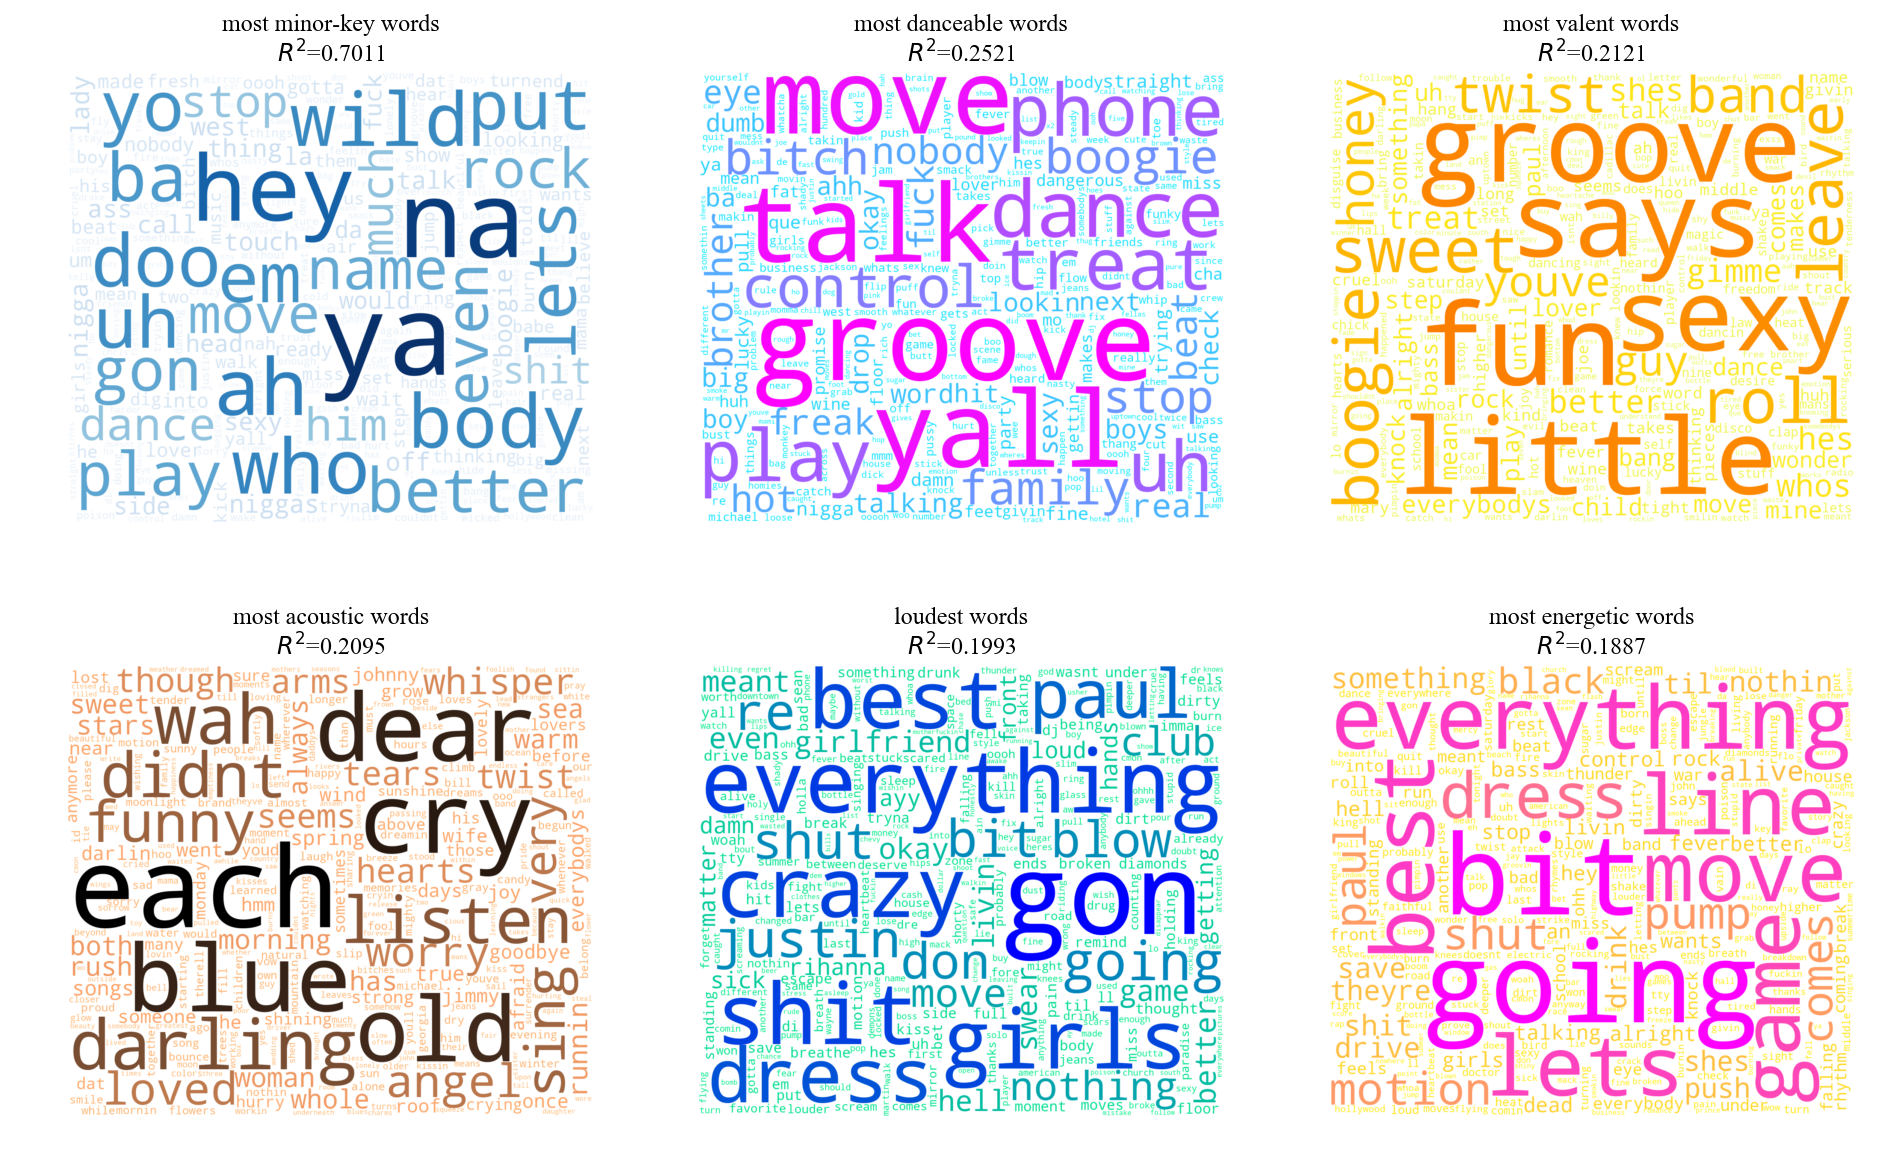

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()
audio_features = ['mode', 'danceability', 'valence', 'acousticness',
                  'loudness', 'energy']
titles = ['most minor-key words', 'most danceable words', 'most valent words',
          'most acoustic words', 'loudest words', 'most energetic words']

cmaps = ['Blues', 'cool', 'Wistia', 'copper_r', 'winter_r', 'spring_r']

count = CountVectorizer(min_df=20, max_df=1000)
X_vect = count.fit_transform(df_nonnull['lyrics'])
for i, feature in enumerate(audio_features):
    if feature != 'mode':
        ridge = RidgeCV(alphas=[1, 3, 10, 30, 1e2, 3e2, 1e3, 2e3, 3e3, 4e3, 1e5,
                                3e5, 1e6])
        ridge.fit(X_vect, df_nonnull[feature])
        score = ridge.score(X_vect, df_nonnull[feature])
    else:
        ridge = LogisticRegressionCV(Cs=[1e-6, 3e-6, 1e-5, 3e-5])
        ridge.fit(X_vect, 1 - df_nonnull[feature])
        score = ridge.scores_[1.].mean(axis=1).max()
    coefs = ridge.coef_
    if feature == 'mode':
        coefs = coefs.squeeze()
    vocab = count.get_feature_names()

    color_func = colormap_size_func(cmaps[i], 300)
    dictionary = dict(zip(vocab, coefs))
    wordcloud = WordCloud(background_color='white', height=1200,
                          min_font_size=5, width=1400, color_func=color_func,
                          max_words=300, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title='{}\n$R^2$={:.4}'.format(titles[i], score))